## Autoencoders, GANs, and Diffusion Models

### Convolutional Autoencoders

In [4]:
import tensorflow as tf

conv_encoder = tf.keras.Sequential([
    tf.keras.layers.Reshape([28,28,1]),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(30, (3,3), activation='relu', padding='same'),
    tf.keras.layers.GlobalAveragePooling2D()
])

conv_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(3 * 3 * 16),
    tf.keras.layers.Reshape([3,3,16]),
    tf.keras.layers.Conv2DTranspose(32, (3,3), strides=2, activation='relu', padding='same'),
    tf.keras.layers.Conv2DTranspose(16, (3,3), strides=2, activation='relu', padding='same'),
    tf.keras.layers.Conv2DTranspose(1, (3,3), strides=2, activation='sigmoid', padding='same'),
    tf.keras.layers.Reshape([28,28])
])

conv_ae = tf.keras.Sequential([conv_encoder, conv_decoder])

### Denoising Autoencoders

In [8]:
import tensorflow as tf

dropout_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu')
])

dropout_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(28*28),
    tf.keras.layers.Reshape([28,28])
])

dropout_ae = tf.keras.Sequential([dropout_encoder, dropout_decoder])

### Sparse Autoencoders

In [4]:
import tensorflow as tf

sparse_l1_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(300, activation='sigmoid'),
    tf.keras.layers.ActivityRegularization(l1=1e-4),
])

sparse_l1_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(28*28),
    tf.keras.layers.Reshape([28,28])
])

sparse_l1_ae = tf.keras.Sequential([sparse_l1_encoder, sparse_l1_decoder])

# KL divergence regularization

kl_divergence = tf.keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, weight, target):
        self.weight = weight
        self.target = target
    
    def __call__(self, inputs):
        mean_activities = tf.reduce_mean(inputs, axis=0)
        return self.weight * (
                kl_divergence(self.target, mean_activities) +
                kl_divergence(1. - self.target, 1. - mean_activities))

kld_reg = KLDivergenceRegularizer(weight=5e-3, target=0.1)

sparse_l1_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(
        300, 
        activation='sigmoid', 
        activity_regularizer=kld_reg
    )
])

sparse_l1_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(28*28),
    tf.keras.layers.Reshape([28,28])
])

### Variational Autoencoders

2025-04-14 06:09:20.807792: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-14 06:09:20.837319: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-14 06:09:20.837400: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-14 06:09:20.838436: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-14 06:09:20.844338: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-14 06:09:20.845047: I tensorflow/core/platform/cpu_feature_guard.cc:1

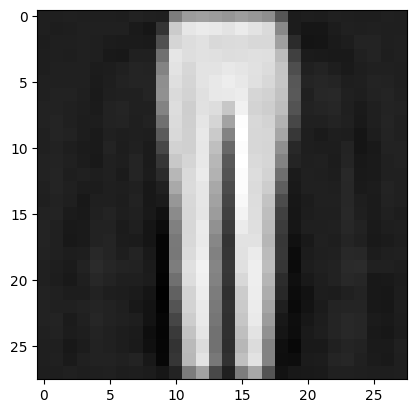

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

class Sampling(tf.keras.layers.Layer):
    def __call__(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

# extra code – loads, scales, and splits the fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

codings_size = 10

inputs = tf.keras.layers.Input(shape=[28,28])
Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(150, activation="relu")(Z)
Z = tf.keras.layers.Dense(100, activation="relu")(Z)

codings_mean = tf.keras.layers.Dense(codings_size)(Z)
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)
codings = Sampling()([codings_mean, codings_log_var])

variational_encoder = tf.keras.Model(
    inputs = [inputs],
    outputs = [codings_mean, codings_log_var, codings]
)

decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(100, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(150, activation="relu")(x)
x = tf.keras.layers.Dense(28 * 28)(x)
outputs = tf.keras.layers.Reshape([28,28])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean), axis=-1)
variational_ae.add_loss(tf.reduce_mean(latent_loss) / 784.)

variational_ae.compile(loss="mse", optimizer="nadam")
history = variational_ae.fit(
    X_train, 
    X_train, 
    epochs=10, 
    batch_size=128,
    validation_data=(X_valid, X_valid)
)

codings = tf.random.normal(shape=[3 * 7, codings_size])
images = variational_decoder(codings).numpy()

plt.imshow(images[0], cmap="gray")
plt.show()

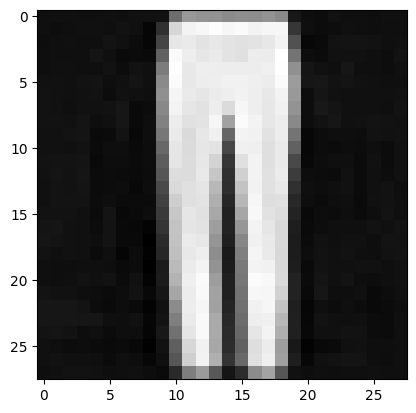

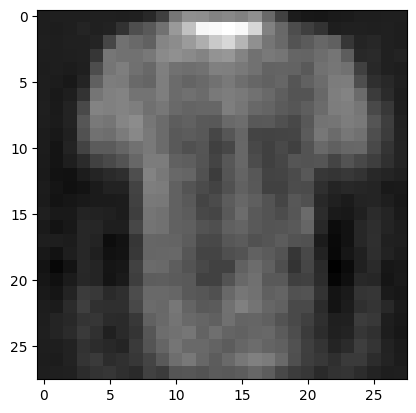

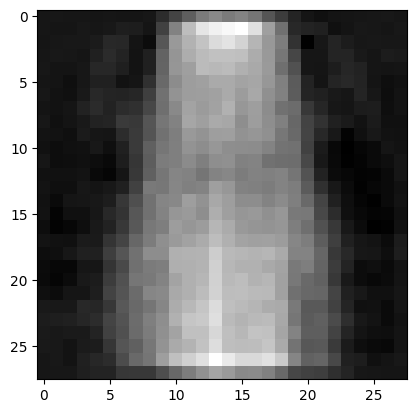

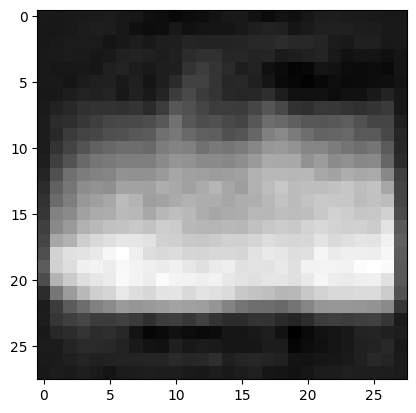

In [5]:
codings = tf.random.normal(shape=[4, codings_size])
images = variational_decoder(codings).numpy()

for image in images:
    plt.imshow(image, cmap="gray")
    plt.show()

### Generative Adversarial Networks

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# extra code – loads, scales, and splits the fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

codings_size = 30

Dense = tf.keras.layers.Dense

generator = tf.keras.Sequential([
    Dense(100, activation="relu", kernel_initializer="he_normal"),
    Dense(150, activation="relu", kernel_initializer="he_normal"),
    Dense(28 * 28, activation="sigmoid"),
    tf.keras.layers.Reshape([28,28])
])
discriminator = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    Dense(150, activation="relu", kernel_initializer="he_normal"),
    Dense(100, activation="relu", kernel_initializer="he_normal"),
    Dense(1, activation="sigmoid")
])
gan = tf.keras.Sequential([generator, discriminator])

discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generatir, discriminator = gan.layers
    for epoch in range(n_epochs):
        for X_batch in dataset:
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([0.] * batch_size + [1.] * batch_size)
            discriminator.train_on_batch(X_fake_and_real, y1)
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([1.] * batch_size)
            gan.train_on_batch(noise, y2)

train_gan(gan, dataset, batch_size, codings_size, n_epochs=10)

2025-04-14 07:07:14.016726: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-14 07:07:14.062539: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-14 07:07:14.062653: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-14 07:07:14.064167: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-14 07:07:14.072912: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-14 07:07:14.073869: I tensorflow/core/platform/cpu_feature_guard.cc:1

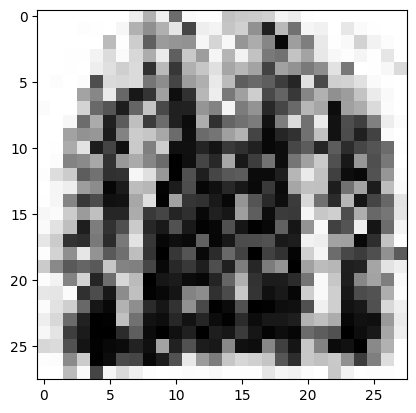

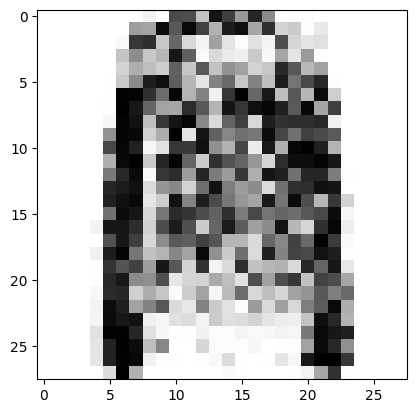

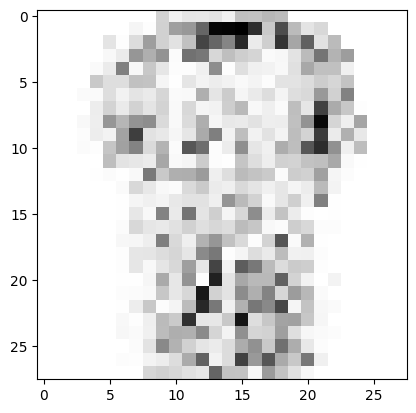

In [17]:
codings = tf.random.normal(shape=[3, codings_size])
images = generator(codings).numpy()

for image in images:
    plt.imshow(image, cmap="binary")
    plt.show()

### Deep Convolutional GANs

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# extra code – loads, scales, and splits the fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1.

codings_size = 100

generator = tf.keras.Sequential([
    tf.keras.layers.Dense(7 * 7 * 128),
    tf.keras.layers.Reshape([7, 7, 128]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="same", activation="tanh"),
])
discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(
        64, 
        kernel_size=5, 
        strides=2, 
        padding="same", 
        activation=tf.keras.layers.LeakyReLU(0.2)
    ),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(
        128, 
        kernel_size=5, 
        strides=2, 
        padding="same", 
        activation=tf.keras.layers.LeakyReLU(0.2)
    ),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
gan = tf.keras.Sequential([generator, discriminator])

discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generatir, discriminator = gan.layers
    for epoch in range(n_epochs):
        for X_batch in dataset:
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([0.] * batch_size + [1.] * batch_size)
            discriminator.train_on_batch(X_fake_and_real, y1)
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([1.] * batch_size)
            gan.train_on_batch(noise, y2)

train_gan(gan, dataset, batch_size, codings_size, n_epochs=10)

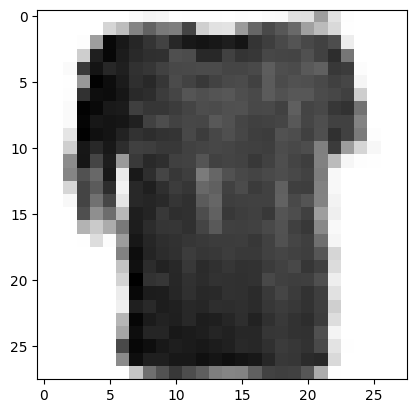

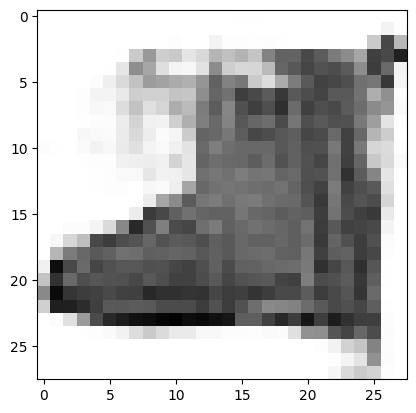

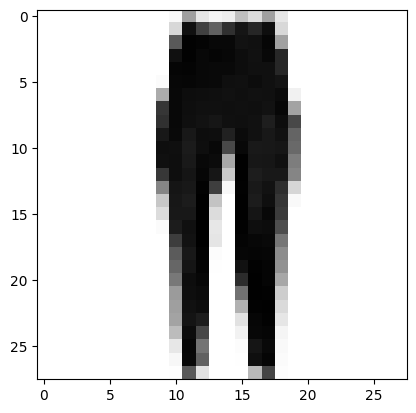

In [25]:
codings = tf.random.normal(shape=[3, codings_size])
images = generator(codings).numpy()

for image in images:
    plt.imshow(image, cmap="binary")
    plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=968d3c27-50e7-4d42-bdd9-442f6904c1c2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>